# Analyze data split using 80-20 Balancing score, Jensen-Shannon distance, % Appearing families

## Setup the data frame and define the functions

In [5]:
from utils.best_split_utils import *
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [7]:
fsd = "first_submission_date"
# Convert the timestamps to datetime format
df_dt = df.copy()
df_dt[fsd] = df_dt[fsd].apply(lambda t: pd.to_datetime(t, unit='s'))

In [8]:
from typing import Callable
from scipy.spatial.distance import jensenshannon
def compute_scores(df: pd.DataFrame, ref_df: pd.DataFrame, date_split: pd.Timestamp):
    """
    Compute the scores given a dataset and a timestamp as data split:
    Jensen-Shannon score, Train-Test balancing, % Appearing families in testing set
    """
    # JS
    df_train_all = split_and_group(src_df=df, split_condition=df[fsd] < date_split, ref_df=ref_df)
    df_test_all = split_and_group(src_df=df, split_condition=df[fsd] >= date_split, ref_df=ref_df)
    js = jensenshannon(np.array(df_train_all["count"]), np.array(df_test_all["count"]))

    # Train-Test balancing: this score increases as the training test length
    # in % is approaching 80% of the samples
    train_prop = len(df[df[fsd] < date_split]) / len(ref_df)
    bs = 1 - np.abs(train_prop - 0.8) / 0.8

    # % Appearing families in testing set
    df_train_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] < date_split)
    df_test_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] >= date_split)

    test_families = df_test_nonzero["family"].unique()
    af = ((len(test_families) - len(np.intersect1d(df_train_nonzero["family"].unique(), test_families))) /
          len(ref_df["family"].unique()))

    return {"js": js, "bs": bs, "af": af}


## Compute the scores using the first day of each month as data splits

In [9]:
# Min and maximum dates
date_min = df_dt[fsd].min()
date_max = df_dt[fsd].max()

date_min_n = pd.Timestamp(f"{date_min.year}-{date_min.month}-{date_min.day}")
date_max_n = pd.Timestamp(f"{date_max.year}-{date_max.month}-{date_max.day}")

# Create 1-month equidistant splits
# "MS": use the Start of each Month from the minimum date to the maximum
date_splits = pd.date_range(start=date_min_n, end=date_max_n, freq="MS").tolist()

In [10]:
df_scores, df_ref_scores = df_dt.copy(), df_dt.copy()
js_scores, perc_app_families, balance_scores = [], [], []
for date_split in date_splits:
    scores = compute_scores(df=df_scores, ref_df=df_ref_scores, date_split=date_split)
    js_scores.append(scores["js"])
    perc_app_families.append(scores["af"])
    balance_scores.append(scores["bs"])

## Plot the 80-20 Balancing score between train and test set

As shown below, the highest balancing score is achieved using 2021-12-01 as the timestamp split.
However, very few number of families are introduced in the test set (9 families, 1.34%). We further investigate the data on the latest years where there's both an increase and peak of $BS$ to see if we can choose a point where the number of appearing families is higher.

Max balance score 0.8575
------------------------------------------------------------------
Report: Best split based on Balance score at: 2021-12-01 00:00:00
	Training set length: 45962, (68.6%)
	Testing set length: 21038, (31.4%)
	Num families in training: 661
	Num families in testing: 611
	Common families: 602
	Families in training but not in testing: 59 (8.81%)
	Families in testing but not in training: 9 (1.34%)


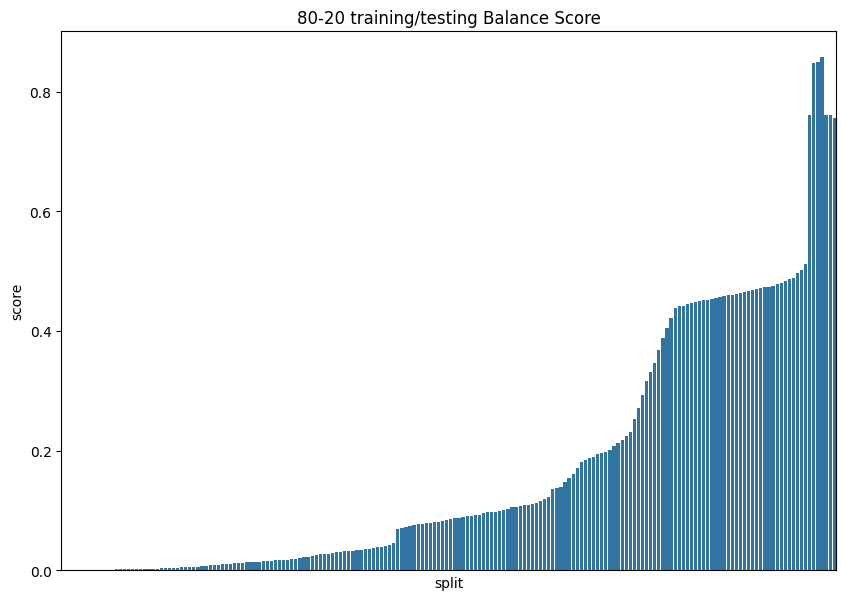

In [11]:
max_bs, idx_max_bs = np.max(balance_scores), np.argmax(balance_scores)

max_bs_split = date_splits[idx_max_bs]
print(f"Max balance score {max_bs}")
print_statistics(df_scores, max_bs_split, f"Best split based on Balance score at: {max_bs_split}")

df_bs = pd.DataFrame({"split": date_splits, "score": balance_scores})
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_bs, x="split", y="score")

plt.title("80-20 training/testing Balance Score")
plt.xticks([])
plt.show()

## Score focus

From later on, the analysis will focus on the latest years, where there's both an increase and peak of $BS$.
Splits at and after 2021-07-01 are considered, where the $BS > 0.5$.

### Observations

- Choosing $BS > 0.5$ implies initiating with a basis comprising 40.18% of the training set length;
- In 2021-08 lots of samples are submitted: at split 2021-08-01 the training length in percentage is 40.92%, and at 2021-09-01 it's 60.93%. In the first case 74 (11.04%) of new families are introduced, 16 in the second (2.39%);
- At 2021-09-01 16 families are introduced in the test set as opposed to 9 of the subsequent three splits, while having 60.93% as training set length;
- From 2021-10-01 to 2021-12-01 (included), the number of appearing families remain stable at 9 (as described before), while the training set length goes from 67.84% to 68.6%;
- In the last three splits (from 2022-01-01) there isn't any new appearing family. Those splits are not interesting to study family drift, so they will be not considered;


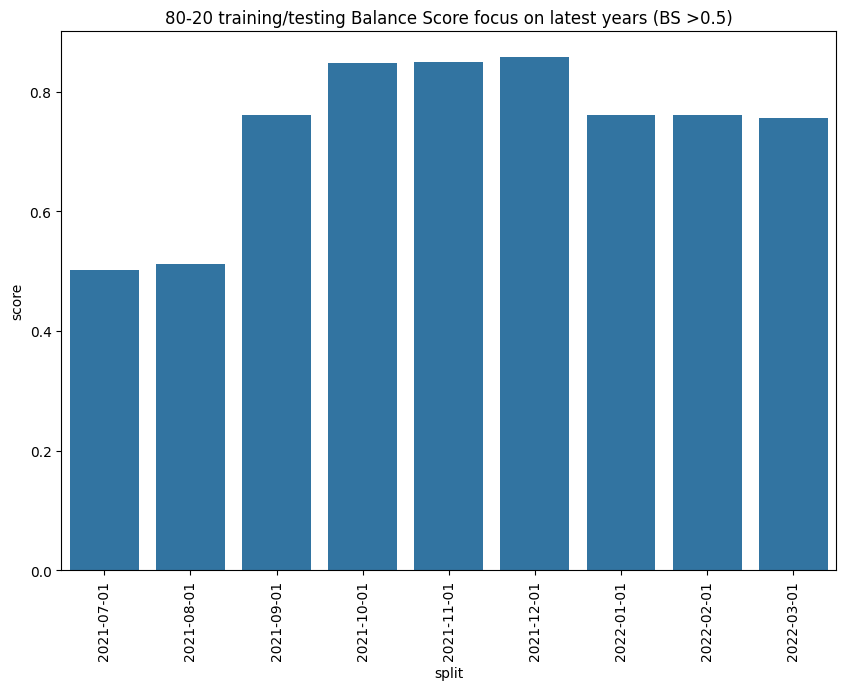

------------------------------------------------------------------
Report: 2021-07-01 00:00:00, BS: 0.502276119402985
	Training set length: 26922, (40.18%)
	Testing set length: 40078, (59.82%)
	Num families in training: 595
	Num families in testing: 650
	Common families: 575
	Families in training but not in testing: 20 (2.99%)
	Families in testing but not in training: 75 (11.19%)
------------------------------------------------------------------
Report: 2021-08-01 00:00:00, BS: 0.5114925373134328
	Training set length: 27416, (40.92%)
	Testing set length: 39584, (59.08%)
	Num families in training: 596
	Num families in testing: 650
	Common families: 576
	Families in training but not in testing: 20 (2.99%)
	Families in testing but not in training: 74 (11.04%)
------------------------------------------------------------------
Report: 2021-09-01 00:00:00, BS: 0.7616044776119403
	Training set length: 40822, (60.93%)
	Testing set length: 26178, (39.07%)
	Num families in training: 654
	Num fam

In [12]:
plt.figure(figsize=(10, 7))

df_bs_focus = df_bs[df_bs["score"] > 0.5]
t_focus = df_bs_focus["split"].min()

ax = sns.barplot(data=df_bs_focus, x="split", y="score")
plt.title(f"80-20 training/testing Balance Score focus on latest years (BS >0.5)")
plt.xticks(rotation=90)
plt.show()

for split in df_bs_focus["split"]:
    print_statistics(df_scores, split, f"{split}, BS: {df_bs_focus[df_bs_focus['split'] == split]['score'].iloc[0]}")

## Jensen-Shannon distance and % Appearing families: Considerations

As discussed before, in the last three bins there isn't any new appearing family in the test set.

The drastic increase of Jensen-Shannon distance is due to the fact that lots of families are disappearing e.g. are seen in the training set but not in the testing set.

In 2021-12-01 8.81% of families are seen only on the training set, while 88.81% at 2022-01-01 .

Those three splits are not interesting for studying family drift.

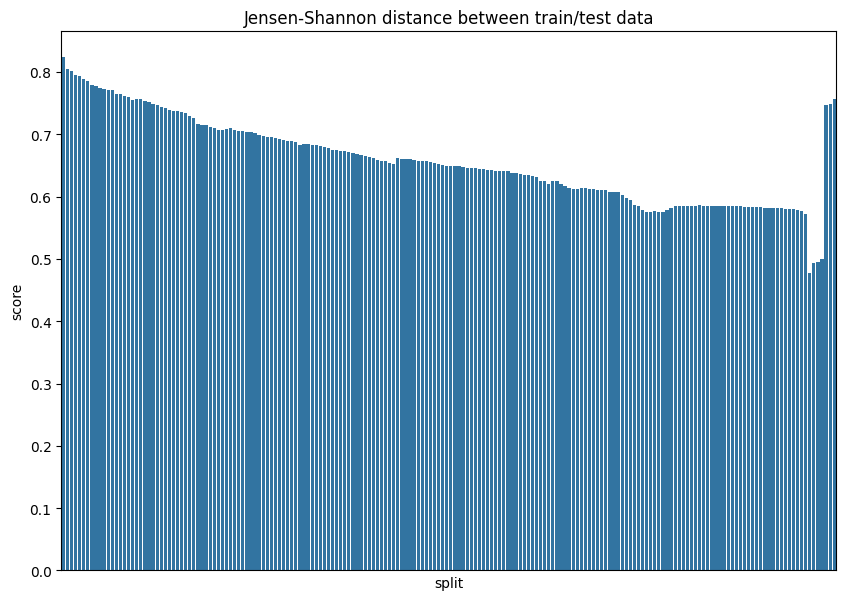

In [13]:
df_js = pd.DataFrame({"split": date_splits, "score": js_scores})
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_js, x="split", y="score")
plt.title("Jensen-Shannon distance between train/test data")
plt.xticks([])
plt.show()

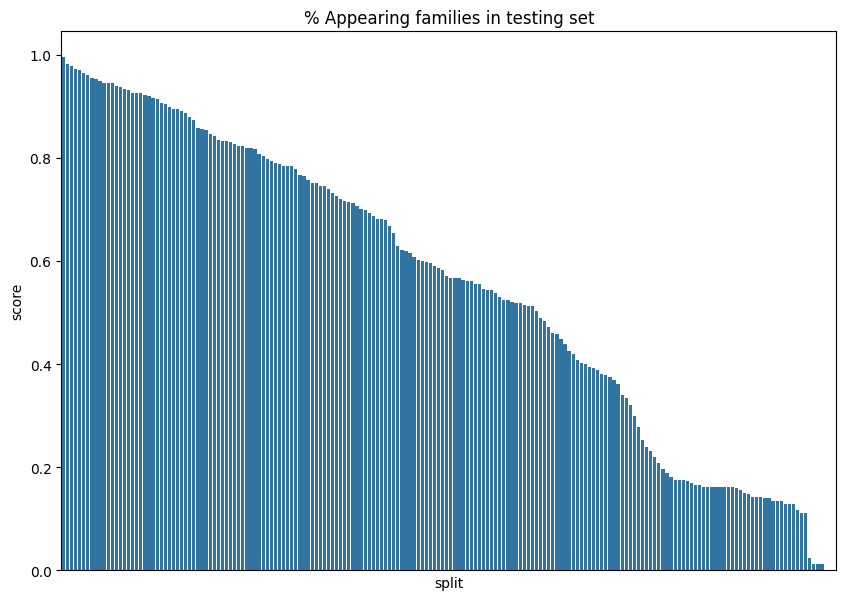

In [14]:
plt.figure(figsize=(10, 7))
df_af = pd.DataFrame({"split": date_splits, "score": perc_app_families})
ax = sns.barplot(data=df_af, x="split", y="score")
plt.title("% Appearing families in testing set")
plt.xticks([])
plt.show()

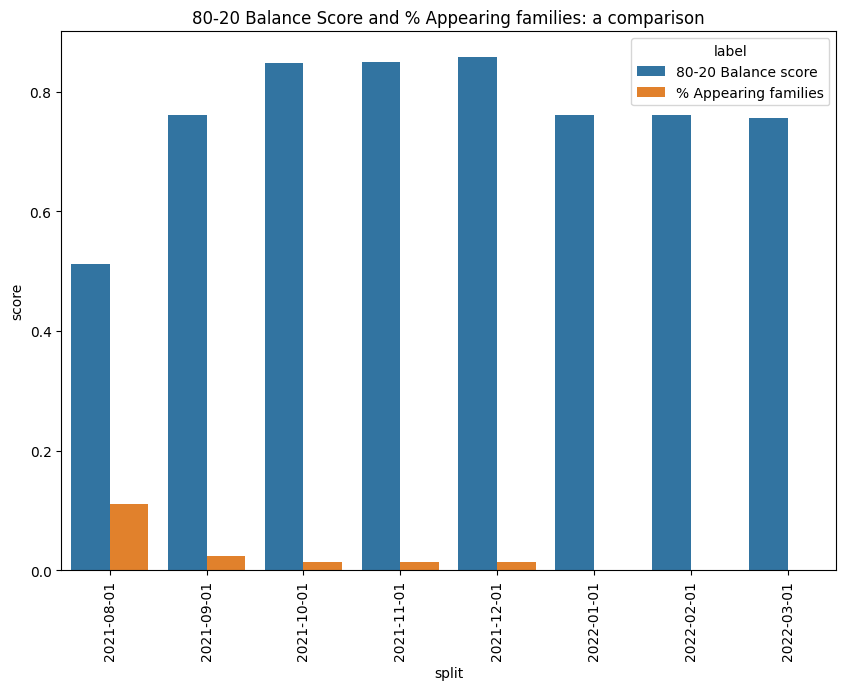

In [15]:
df_bs["label"] = "80-20 Balance score"
df_js["label"] = "Jensen Shannon distance"
df_af["label"] = "% Appearing families"

df_concat_scores = pd.concat([df_bs, df_af])
df_concat_scores = df_concat_scores[df_concat_scores["split"] > t_focus]

plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_concat_scores, x="split", hue="label", y="score")
plt.title("80-20 Balance Score and % Appearing families: a comparison")
plt.xticks(rotation=90)
plt.show()

## Best split based on 80-20 Training-Test Balance Score and % Appearing families

Using $BS > 0.5$ e.g. 40.18% of the training set length as a basis, the best split is computed using $BS$ + % Appearing families as optimization criteria.

In [16]:
df_merge_scores = pd.merge(left=df_bs, right=df_af, on="split")
df_merge_scores = df_merge_scores[df_merge_scores["split"] > t_focus]
s_scores = df_merge_scores["score_x"] + df_merge_scores["score_y"]

max_v, max_v_idx = np.max(s_scores), np.argmax(s_scores)
best_split = list(df_merge_scores['split'])[max_v_idx]
print_statistics(df_scores, best_split, best_split)

------------------------------------------------------------------
Report: 2021-12-01 00:00:00
	Training set length: 45962, (68.6%)
	Testing set length: 21038, (31.4%)
	Num families in training: 661
	Num families in testing: 611
	Common families: 602
	Families in training but not in testing: 59 (8.81%)
	Families in testing but not in training: 9 (1.34%)


## Conclusions

Using a Training-Testing Balance score that increases when the training set length is approaching 80% of the overall data + % of appearing families in the test set gives 2021-12-01 as the best split, with new 9 families seen in the testing set.

As described before, there's another time split that is interesting to consider: 2021-09-01.
The training set here is composed of ~60% of data points (still has a large percentage of samples) and 16 families are appearing in the testing set, as opposed to 9.

This indicates that the Training-Testing balance score isn't much appropriate because it linearly decrease as the percentage deviates from 80%, impacting too much negatively for still quite good splits.

Furthermore, equidistant splits of one day might be considered on later analysis, especially for 2021-08, where a sudden increase of training set length verifies (40.92% to 60.93%).